# 注意点：文件名、lr、error tag、categorical_feature

# 1 导入库和读取数据

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

path = '/home/agwave/Data/used-car/'
Train_data = pd.read_hdf('Train_data_best.h5')
Test_data = pd.read_hdf('Test_data_best.h5')

In [2]:
print(Train_data.shape)
print(Test_data.shape)

(150000, 64)
(50000, 64)


In [3]:
Y_data = Train_data.price
X_data = Train_data.drop('price', axis=1)

X_test = Test_data.drop('SaleID', axis=1)

In [4]:
X_data.head()

,power,kilometer,usedDay,v_0,v_1,v_2,v_3,v_4,v_5,v_6,...,model_kilometer_mean,is_caiyou_car_brand_mean,is_caiyou_car_model_mean,is_caiyou_car_powerRange_mean,v_sum,v_std,v_skew,v_median,v_max,v_min
0,60,12.5,4385,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,...,2267.407609,2887.676515,2613.907354,2700.977119,7.119150,1.790512,-0.097517,0.182612,3.966344,-2.881803
1,0,15.0,4757,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,...,5072.496821,7543.488689,5030.648292,2211.556378,0.589442,2.217817,0.169456,0.128367,5.236112,-4.900482
2,163,12.5,4382,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,...,8120.729323,9460.582761,10444.576127,6259.852107,2.228145,2.088335,-0.190080,0.088543,4.823792,-4.846749
3,193,15.0,7125,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,...,10447.236593,7371.301224,10993.332046,8071.047286,-3.005148,2.034433,0.115087,0.016697,4.492574,-4.509599
4,68,5.0,1531,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,...,4239.937500,2888.178109,1571.230038,2700.977119,8.575578,1.353860,-0.228995,0.400102,2.834518,-1.896240


In [5]:
X_data.columns

Index(['power', 'kilometer', 'usedDay', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14', 'model_mean', 'brand_mean', 'usedMonth_mean', 'usedYear_mean',
       'creatMonth_mean', 'regMonth_mean', 'bodyType_mean', 'kilometer_mean',
       'powerRange_mean', 'fuelType_mean', 'gearbox_mean',
       'notRepairedDamage_mean', 'v_7_bins_mean', 'v_4_bins_mean',
       'v_13_bins_mean', 'v_14_bins_mean', 'fuelType_gearbox_mean',
       'brand_bodyType_mean', 'brand_notRepairedDamage_mean',
       'model_notRepairedDamage_mean', 'model_bodyType_mean',
       'bodyType_notRepairedDamage_mean', 'brand_model_notRepairedDamage_mean',
       'brand_bodyType_notRepairedDamage_mean',
       'fuelType_gearbox_notRepairedDamage_mean', 'brand_kilometer_mean',
       'fuelType_powerRange_mean', 'powerRange_gearbox_mean',
       'kilometer_notRepairedDamage_mean', 'is_little_car_brand_mean',
       'model_powerRange_mean', 'is_little

# 2 模型与训练

In [6]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error

In [7]:
logging.basicConfig(level=logging.INFO, filename='log.txt', format='%(asctime)s: %(message)s')

## 2.1 Lightgbm

In [8]:
params = {'num_leaves': 127,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 7,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
#          "nthread": 4,
         "random_state": 4590}

categorical_features = ['model']
# param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2],}

In [9]:
features = [c for c in X_data]
feature_importance = pd.DataFrame()

models = []
oof = np.zeros(len(Y_data))
predictions = np.zeros(len(X_test))

folds = KFold(n_splits=5, shuffle=True, random_state=4590)
start = time.time()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_data, Y_data)):
    print('fold {}'.format(fold_))
    trn_data = lgb.Dataset(X_data.iloc[trn_idx], label=Y_data.iloc[trn_idx])
    val_data = lgb.Dataset(X_data.iloc[val_idx], label=Y_data.iloc[val_idx])
    model = lgb.train(params, trn_data, 100000, valid_sets=[trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = model.predict(X_data.iloc[val_idx], num_iteration=model.best_iteration)
    models.append(model)
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = features
    fold_importance['importance'] = model.feature_importance()
    fold_importance['fold'] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    predictions += model.predict(X_test, num_iteration=model.best_iteration) / folds.n_splits
print(time.time()-start)
error = mean_absolute_error(oof, Y_data)
print('error: {}'.format(error))
tag = input('请输入tag')
logging.info(str(round(error, 1)) + '    ({})'.format(tag))

fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 2053.86	valid_1's l1: 2051.82
[200]	training's l1: 1052.13	valid_1's l1: 1071.96
[300]	training's l1: 737.209	valid_1's l1: 771.974
[400]	training's l1: 637.342	valid_1's l1: 680.45
[500]	training's l1: 598.928	valid_1's l1: 645.537
[600]	training's l1: 581.116	valid_1's l1: 629.82
[700]	training's l1: 569.177	valid_1's l1: 620.293
[800]	training's l1: 559.971	valid_1's l1: 613.638
[900]	training's l1: 552	valid_1's l1: 608.071
[1000]	training's l1: 544.725	valid_1's l1: 603.266
[1100]	training's l1: 537.56	valid_1's l1: 598.641
[1200]	training's l1: 531.078	valid_1's l1: 594.529
[1300]	training's l1: 525.058	valid_1's l1: 590.854
[1400]	training's l1: 519.429	valid_1's l1: 587.468
[1500]	training's l1: 513.295	valid_1's l1: 583.679
[1600]	training's l1: 508.417	valid_1's l1: 580.862
[1700]	training's l1: 503.232	valid_1's l1: 577.914
[1800]	training's l1: 498.117	valid_1's l1: 574.951
[1900]	trai

[15700]	training's l1: 234.668	valid_1's l1: 490.093
[15800]	training's l1: 233.757	valid_1's l1: 490.002
[15900]	training's l1: 232.811	valid_1's l1: 489.933
[16000]	training's l1: 231.917	valid_1's l1: 489.868
[16100]	training's l1: 231.003	valid_1's l1: 489.773
[16200]	training's l1: 230.112	valid_1's l1: 489.706
[16300]	training's l1: 229.187	valid_1's l1: 489.626
[16400]	training's l1: 228.232	valid_1's l1: 489.512
[16500]	training's l1: 227.412	valid_1's l1: 489.451
[16600]	training's l1: 226.511	valid_1's l1: 489.388
[16700]	training's l1: 225.606	valid_1's l1: 489.282
[16800]	training's l1: 224.722	valid_1's l1: 489.195
[16900]	training's l1: 223.832	valid_1's l1: 489.126
[17000]	training's l1: 222.969	valid_1's l1: 489.066
[17100]	training's l1: 222.178	valid_1's l1: 489.026
[17200]	training's l1: 221.354	valid_1's l1: 488.942
[17300]	training's l1: 220.464	valid_1's l1: 488.842
[17400]	training's l1: 219.577	valid_1's l1: 488.777
[17500]	training's l1: 218.745	valid_1's l1: 4

[6300]	training's l1: 362.905	valid_1's l1: 516.593
[6400]	training's l1: 360.969	valid_1's l1: 516.024
[6500]	training's l1: 358.962	valid_1's l1: 515.462
[6600]	training's l1: 357.034	valid_1's l1: 514.824
[6700]	training's l1: 355.147	valid_1's l1: 514.281
[6800]	training's l1: 353.144	valid_1's l1: 513.778
[6900]	training's l1: 351.335	valid_1's l1: 513.427
[7000]	training's l1: 349.549	valid_1's l1: 512.888
[7100]	training's l1: 347.738	valid_1's l1: 512.407
[7200]	training's l1: 345.997	valid_1's l1: 511.959
[7300]	training's l1: 344.186	valid_1's l1: 511.512
[7400]	training's l1: 342.417	valid_1's l1: 511.098
[7500]	training's l1: 340.657	valid_1's l1: 510.704
[7600]	training's l1: 338.843	valid_1's l1: 510.258
[7700]	training's l1: 337.108	valid_1's l1: 509.791
[7800]	training's l1: 335.413	valid_1's l1: 509.454
[7900]	training's l1: 333.647	valid_1's l1: 509.09
[8000]	training's l1: 331.962	valid_1's l1: 508.683
[8100]	training's l1: 330.365	valid_1's l1: 508.395
[8200]	traini

[22000]	training's l1: 188.323	valid_1's l1: 489.636
[22100]	training's l1: 187.68	valid_1's l1: 489.593
[22200]	training's l1: 187.07	valid_1's l1: 489.571
[22300]	training's l1: 186.414	valid_1's l1: 489.539
[22400]	training's l1: 185.812	valid_1's l1: 489.49
[22500]	training's l1: 185.197	valid_1's l1: 489.448
[22600]	training's l1: 184.577	valid_1's l1: 489.421
[22700]	training's l1: 183.97	valid_1's l1: 489.376
[22800]	training's l1: 183.422	valid_1's l1: 489.355
[22900]	training's l1: 182.79	valid_1's l1: 489.323
[23000]	training's l1: 182.222	valid_1's l1: 489.304
[23100]	training's l1: 181.635	valid_1's l1: 489.281
[23200]	training's l1: 181.045	valid_1's l1: 489.232
[23300]	training's l1: 180.432	valid_1's l1: 489.204
[23400]	training's l1: 179.862	valid_1's l1: 489.181
[23500]	training's l1: 179.281	valid_1's l1: 489.17
[23600]	training's l1: 178.71	valid_1's l1: 489.133
[23700]	training's l1: 178.098	valid_1's l1: 489.107
[23800]	training's l1: 177.477	valid_1's l1: 489.057


[8300]	training's l1: 327.461	valid_1's l1: 504.047
[8400]	training's l1: 325.776	valid_1's l1: 503.648
[8500]	training's l1: 324.095	valid_1's l1: 503.321
[8600]	training's l1: 322.471	valid_1's l1: 503.005
[8700]	training's l1: 320.84	valid_1's l1: 502.674
[8800]	training's l1: 319.297	valid_1's l1: 502.334
[8900]	training's l1: 317.72	valid_1's l1: 502.053
[9000]	training's l1: 316.154	valid_1's l1: 501.773
[9100]	training's l1: 314.645	valid_1's l1: 501.453
[9200]	training's l1: 313.261	valid_1's l1: 501.243
[9300]	training's l1: 311.727	valid_1's l1: 500.895
[9400]	training's l1: 310.21	valid_1's l1: 500.602
[9500]	training's l1: 308.736	valid_1's l1: 500.335
[9600]	training's l1: 307.309	valid_1's l1: 500.083
[9700]	training's l1: 305.928	valid_1's l1: 499.846
[9800]	training's l1: 304.505	valid_1's l1: 499.594
[9900]	training's l1: 303.104	valid_1's l1: 499.325
[10000]	training's l1: 301.762	valid_1's l1: 499.074
[10100]	training's l1: 300.46	valid_1's l1: 498.91
[10200]	trainin

fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 2054.6	valid_1's l1: 2041.47
[200]	training's l1: 1053.07	valid_1's l1: 1066.87
[300]	training's l1: 737.988	valid_1's l1: 764.699
[400]	training's l1: 638.231	valid_1's l1: 672.172
[500]	training's l1: 601.182	valid_1's l1: 639.236
[600]	training's l1: 584.274	valid_1's l1: 625.148
[700]	training's l1: 571.958	valid_1's l1: 615.708
[800]	training's l1: 562.362	valid_1's l1: 609.098
[900]	training's l1: 554.306	valid_1's l1: 603.675
[1000]	training's l1: 546.841	valid_1's l1: 598.773
[1100]	training's l1: 540.029	valid_1's l1: 594.566
[1200]	training's l1: 532.882	valid_1's l1: 590.106
[1300]	training's l1: 526.047	valid_1's l1: 585.804
[1400]	training's l1: 519.595	valid_1's l1: 581.846
[1500]	training's l1: 514.512	valid_1's l1: 579.146
[1600]	training's l1: 508.959	valid_1's l1: 576.006
[1700]	training's l1: 503.472	valid_1's l1: 572.819
[1800]	training's l1: 498.45	valid_1's l1: 570.029
[1900]

[15700]	training's l1: 235.9	valid_1's l1: 488.576
[15800]	training's l1: 235.044	valid_1's l1: 488.505
[15900]	training's l1: 234.198	valid_1's l1: 488.423
[16000]	training's l1: 233.32	valid_1's l1: 488.374
[16100]	training's l1: 232.455	valid_1's l1: 488.296
[16200]	training's l1: 231.619	valid_1's l1: 488.294
[16300]	training's l1: 230.776	valid_1's l1: 488.204
[16400]	training's l1: 229.915	valid_1's l1: 488.138
[16500]	training's l1: 229.07	valid_1's l1: 488.022
[16600]	training's l1: 228.222	valid_1's l1: 487.94
[16700]	training's l1: 227.384	valid_1's l1: 487.885
[16800]	training's l1: 226.529	valid_1's l1: 487.815
[16900]	training's l1: 225.724	valid_1's l1: 487.721
[17000]	training's l1: 224.923	valid_1's l1: 487.682
[17100]	training's l1: 224.154	valid_1's l1: 487.618
[17200]	training's l1: 223.38	valid_1's l1: 487.563
[17300]	training's l1: 222.561	valid_1's l1: 487.498
[17400]	training's l1: 221.746	valid_1's l1: 487.42
[17500]	training's l1: 220.926	valid_1's l1: 487.355


[8200]	training's l1: 330.599	valid_1's l1: 511.681
[8300]	training's l1: 328.995	valid_1's l1: 511.357
[8400]	training's l1: 327.351	valid_1's l1: 511.062
[8500]	training's l1: 325.782	valid_1's l1: 510.816
[8600]	training's l1: 324.206	valid_1's l1: 510.486
[8700]	training's l1: 322.544	valid_1's l1: 510.163
[8800]	training's l1: 321.016	valid_1's l1: 509.879
[8900]	training's l1: 319.448	valid_1's l1: 509.638
[9000]	training's l1: 317.938	valid_1's l1: 509.369
[9100]	training's l1: 316.28	valid_1's l1: 509.062
[9200]	training's l1: 314.775	valid_1's l1: 508.802
[9300]	training's l1: 313.262	valid_1's l1: 508.547
[9400]	training's l1: 311.751	valid_1's l1: 508.21
[9500]	training's l1: 310.348	valid_1's l1: 507.882
[9600]	training's l1: 308.959	valid_1's l1: 507.67
[9700]	training's l1: 307.537	valid_1's l1: 507.415
[9800]	training's l1: 306.043	valid_1's l1: 507.228
[9900]	training's l1: 304.629	valid_1's l1: 507.03
[10000]	training's l1: 303.184	valid_1's l1: 506.766
[10100]	trainin

[23800]	training's l1: 179.625	valid_1's l1: 494.665
[23900]	training's l1: 179.075	valid_1's l1: 494.619
[24000]	training's l1: 178.49	valid_1's l1: 494.588
[24100]	training's l1: 177.891	valid_1's l1: 494.542
[24200]	training's l1: 177.325	valid_1's l1: 494.52
[24300]	training's l1: 176.741	valid_1's l1: 494.479
[24400]	training's l1: 176.196	valid_1's l1: 494.458
[24500]	training's l1: 175.621	valid_1's l1: 494.425
[24600]	training's l1: 175.041	valid_1's l1: 494.413
[24700]	training's l1: 174.469	valid_1's l1: 494.398
[24800]	training's l1: 173.904	valid_1's l1: 494.367
[24900]	training's l1: 173.368	valid_1's l1: 494.341
[25000]	training's l1: 172.793	valid_1's l1: 494.311
[25100]	training's l1: 172.246	valid_1's l1: 494.297
[25200]	training's l1: 171.687	valid_1's l1: 494.278
[25300]	training's l1: 171.159	valid_1's l1: 494.256
[25400]	training's l1: 170.618	valid_1's l1: 494.248
[25500]	training's l1: 170.07	valid_1's l1: 494.221
[25600]	training's l1: 169.551	valid_1's l1: 494.

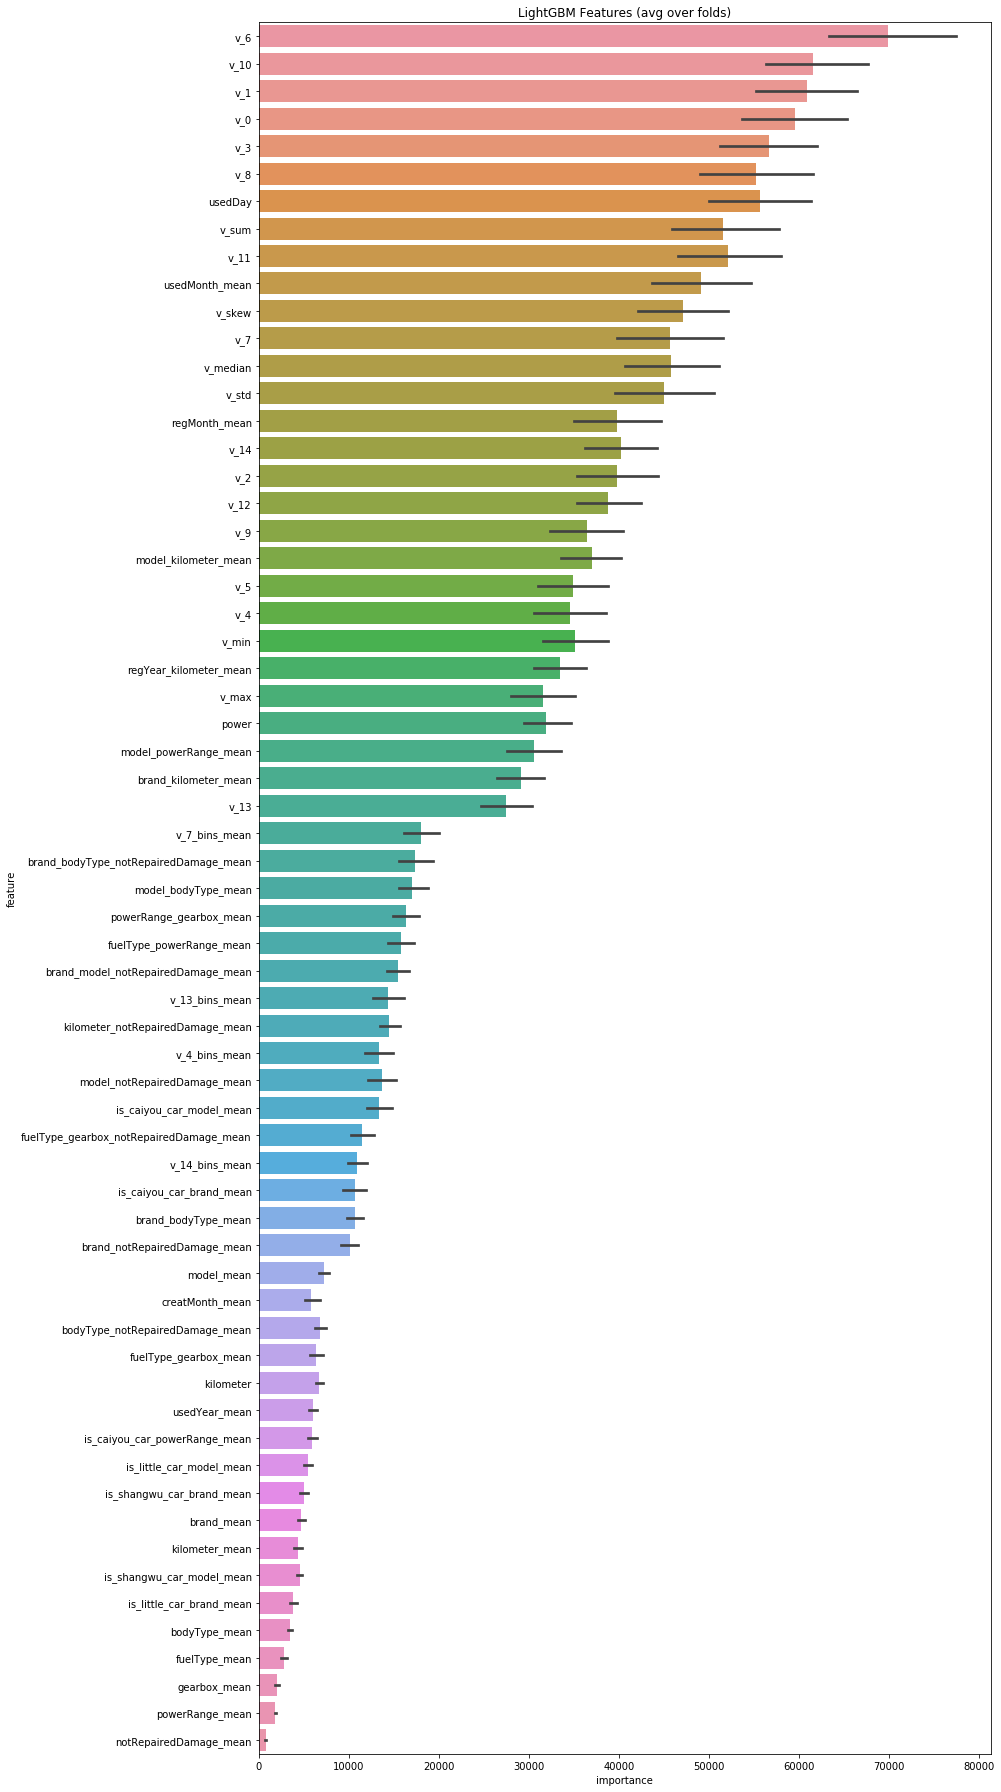

In [10]:
cols = (feature_importance[['feature', 'importance']]
       .groupby('feature')
       .mean()
       .sort_values(by='importance', ascending=False)[:1000].index)
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

## 2.2 Xgboost

In [11]:
xgb_params = {'max_depth': 8,
             'eta': 0.01,
             'objective': 'reg:squarederror',
#              'nthread': 4,
             'eval_metric': 'mae',
             'booster': 'gbtree',
             'subsample': 0.9,
             'min_child_weight': 1,
             'colsample_bytree': 0.8,
#          'scale_pos_weight': 0.1,
#          'gamma': 0.2,            
             'lambda': 10
         }

In [12]:
import xgboost as xgb

xgb_models = []
xgb_oof = np.zeros(len(Y_data))
xgb_predictions = np.zeros(len(X_test))

flods = KFold(n_splits=5, shuffle=True, random_state=4590)
start = time.time()
for fold_, (trn_idx, val_idx) in enumerate(flods.split(X_data, Y_data)):
    print('fold {}'.format(fold_))
    trn_data = xgb.DMatrix(X_data.iloc[trn_idx], label=Y_data.iloc[trn_idx])
    val_data = xgb.DMatrix(X_data.iloc[val_idx], label=Y_data.iloc[val_idx])
    model = xgb.train(xgb_params, trn_data, 100000, evals=[(trn_data, 'train'), (val_data, 'valid')], verbose_eval=100, early_stopping_rounds=100)
    xgb_oof[val_idx] = model.predict(xgb.DMatrix(X_data.iloc[val_idx]), ntree_limit=model.best_ntree_limit)
    xgb_models.append(model)
    xgb_predictions += model.predict(xgb.DMatrix(X_test)) / folds.n_splits
print(time.time()-start)
xgb_error = mean_absolute_error(xgb_oof, Y_data)
print('error: {}'.format(xgb_error))
tag = input('请输入tag')
logging.info(str(round(xgb_error, 1)) + '    ({})'.format(tag))

fold 0
[0]	train-mae:5873.21	valid-mae:5829.69
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[100]	train-mae:2231.96	valid-mae:2219.58
[200]	train-mae:1014.81	valid-mae:1035.19
[300]	train-mae:670.333	valid-mae:718.289
[400]	train-mae:578.645	valid-mae:642.271
[500]	train-mae:547.719	valid-mae:619.177
[600]	train-mae:534.012	valid-mae:609.791
[700]	train-mae:526.017	valid-mae:604.298
[800]	train-mae:520.128	valid-mae:600.376
[900]	train-mae:514.36	valid-mae:596.147
[1000]	train-mae:508.801	valid-mae:592.087
[1100]	train-mae:502.597	valid-mae:587.819
[1200]	train-mae:496.792	valid-mae:583.783
[1300]	train-mae:491.287	valid-mae:580.431
[1400]	train-mae:485.021	valid-mae:576.581
[1500]	train-mae:479.252	valid-mae:573.188
[1600]	train-mae:472.988	valid-mae:569.685
[1700]	train-mae:465.27	valid-mae:565.178
[1800]	train-mae:458.176	valid-mae:561.306
[1900]	train-mae:451.428	valid-mae:557.828
[20

[18700]	train-mae:113.893	valid-mae:477.932
[18800]	train-mae:113.244	valid-mae:477.888
[18900]	train-mae:112.648	valid-mae:477.845
[19000]	train-mae:111.998	valid-mae:477.799
[19100]	train-mae:111.381	valid-mae:477.756
[19200]	train-mae:110.778	valid-mae:477.715
[19300]	train-mae:110.194	valid-mae:477.664
[19400]	train-mae:109.594	valid-mae:477.627
[19500]	train-mae:109.004	valid-mae:477.59
[19600]	train-mae:108.378	valid-mae:477.514
[19700]	train-mae:107.807	valid-mae:477.474
[19800]	train-mae:107.204	valid-mae:477.42
[19900]	train-mae:106.631	valid-mae:477.389
[20000]	train-mae:106.088	valid-mae:477.344
[20100]	train-mae:105.529	valid-mae:477.324
[20200]	train-mae:104.956	valid-mae:477.275
[20300]	train-mae:104.398	valid-mae:477.244
[20400]	train-mae:103.841	valid-mae:477.202
[20500]	train-mae:103.303	valid-mae:477.166
[20600]	train-mae:102.766	valid-mae:477.139
[20700]	train-mae:102.234	valid-mae:477.096
[20800]	train-mae:101.676	valid-mae:477.042
[20900]	train-mae:101.171	valid-ma

[37400]	train-mae:47.9332	valid-mae:473.596
[37500]	train-mae:47.7439	valid-mae:473.59
[37600]	train-mae:47.5373	valid-mae:473.575
[37700]	train-mae:47.3478	valid-mae:473.565
[37800]	train-mae:47.157	valid-mae:473.548
[37900]	train-mae:46.9658	valid-mae:473.539
[38000]	train-mae:46.7747	valid-mae:473.532
[38100]	train-mae:46.5844	valid-mae:473.525
[38200]	train-mae:46.3918	valid-mae:473.512
[38300]	train-mae:46.214	valid-mae:473.496
[38400]	train-mae:46.0407	valid-mae:473.488
[38500]	train-mae:45.8634	valid-mae:473.473
[38600]	train-mae:45.6804	valid-mae:473.462
[38700]	train-mae:45.5054	valid-mae:473.449
[38800]	train-mae:45.3314	valid-mae:473.44
[38900]	train-mae:45.146	valid-mae:473.43
[39000]	train-mae:44.9756	valid-mae:473.417
[39100]	train-mae:44.7891	valid-mae:473.398
[39200]	train-mae:44.6087	valid-mae:473.387
[39300]	train-mae:44.4303	valid-mae:473.377
[39400]	train-mae:44.254	valid-mae:473.362
[39500]	train-mae:44.0765	valid-mae:473.355
[39600]	train-mae:43.8996	valid-mae:473

[56200]	train-mae:24.1903	valid-mae:471.897
[56300]	train-mae:24.112	valid-mae:471.892
[56400]	train-mae:24.0329	valid-mae:471.886
[56500]	train-mae:23.9515	valid-mae:471.88
[56600]	train-mae:23.8737	valid-mae:471.874
[56700]	train-mae:23.7974	valid-mae:471.869
[56800]	train-mae:23.7183	valid-mae:471.864
[56900]	train-mae:23.64	valid-mae:471.857
[57000]	train-mae:23.5589	valid-mae:471.85
[57100]	train-mae:23.4801	valid-mae:471.844
[57200]	train-mae:23.404	valid-mae:471.839
[57300]	train-mae:23.3287	valid-mae:471.834
[57400]	train-mae:23.2583	valid-mae:471.829
[57500]	train-mae:23.1805	valid-mae:471.824
[57600]	train-mae:23.1044	valid-mae:471.817
[57700]	train-mae:23.0245	valid-mae:471.813
[57800]	train-mae:22.9466	valid-mae:471.806
[57900]	train-mae:22.8705	valid-mae:471.801
[58000]	train-mae:22.7973	valid-mae:471.796
[58100]	train-mae:22.7272	valid-mae:471.791
[58200]	train-mae:22.6577	valid-mae:471.784
[58300]	train-mae:22.5861	valid-mae:471.777
[58400]	train-mae:22.5134	valid-mae:47

[75000]	train-mae:13.7532	valid-mae:471.1
[75100]	train-mae:13.7143	valid-mae:471.097
[75200]	train-mae:13.6776	valid-mae:471.094
[75300]	train-mae:13.6397	valid-mae:471.09
[75400]	train-mae:13.6027	valid-mae:471.087
[75500]	train-mae:13.5661	valid-mae:471.084
[75600]	train-mae:13.5301	valid-mae:471.081
[75700]	train-mae:13.4948	valid-mae:471.08
[75800]	train-mae:13.4585	valid-mae:471.078
[75900]	train-mae:13.4214	valid-mae:471.073
[76000]	train-mae:13.3887	valid-mae:471.071
[76100]	train-mae:13.3526	valid-mae:471.068
[76200]	train-mae:13.3162	valid-mae:471.066
[76300]	train-mae:13.279	valid-mae:471.062
[76400]	train-mae:13.2439	valid-mae:471.061
[76500]	train-mae:13.2101	valid-mae:471.058
[76600]	train-mae:13.1767	valid-mae:471.055
[76700]	train-mae:13.1406	valid-mae:471.052
[76800]	train-mae:13.106	valid-mae:471.049
[76900]	train-mae:13.0683	valid-mae:471.046
[77000]	train-mae:13.0339	valid-mae:471.044
[77100]	train-mae:12.9998	valid-mae:471.041
[77200]	train-mae:12.9651	valid-mae:47

KeyboardInterrupt: 

## 2.3 模型融合

In [ ]:
# 验证集
val_ensemble = (1-error/(error+xgb_error))*xgb_oof + (1-xgb_error/(error+xgb_error))*oof
ensemble_error = mean_absolute_error(Y_data, val_ensemble)
print('MAE of val with Weighted ensemble:', ensemble_error)
# tag = input('请输入tag')
# logging.info(str(round(ensemble_error, 1)) + '    ({})'.format(tag))

In [ ]:
# 测试集
pred_ensemble = (1-error/(error+xgb_error))*xgb_predictions + (1-xgb_error/(error+xgb_error))*predictions

# 3 预测

### 3.1 保存结果

In [26]:
result = pd.DataFrame()
result['SaleID'] = Test_data['SaleID']
result['price'] = predictions
result.head()

,SaleID,price
0,150000,38591.398307
1,150001,308.177823
2,150002,6257.209070
3,150003,11828.976780
4,150004,636.397293


In [27]:
# save_name = input('请输入保存的文件的名字(.csv)')
# save_path = 'result/' + save_name
result.to_csv('lgb_best_0411.csv', index=False)

### 3.2 结果分析

In [20]:
oof_target = pd.DataFrame()
oof_target['oof'] = oof
oof_target['target'] = Y_data
oof_target['sub'] = oof - Y_data
oof_target.to_csv('result/oof_target.csv')

In [21]:
sub = oof_target['sub']
print(sub.mean())
print(sub.median())
print(sub.max())
print(sub.min())

-4.314300416193168
4.089640691846398
38514.82881505389
-93581.05742659216


In [18]:
oof_target

,oof,target,sub
0,1849.317738,1850,-0.682262
1,3586.914594,3600,-13.085406
2,6281.139453,6222,59.139453
3,2388.106070,2400,-11.893930
4,5169.379292,5200,-30.620708
5,8001.488987,8000,1.488987
6,3501.783019,3500,1.783019
7,1000.569374,1000,0.569374
8,2850.700056,2850,0.700056
9,649.194734,650,-0.805266


In [22]:
# high_error = oof_target[sub>5000].merge(X_data.iloc[sub[sub > 5000].index], on=oof_target[sub>5000].index)
# high_error.head()

In [23]:
# import json
# import os

# if os.path.exists('error_sample.json'):
#     with open('error_sample.json') as j:
#         error_sample = json.load(j)
# else:
#     error_sample = [0] * 150000
# # for idx in high_error.key_0:
# #     error_sample[idx] += 1
# with open('error_sample.json', 'w+') as j:
#     json.dump(error_sample, j)

In [ ]:
# idx_to_cnt = {}
# for idx in range(len(error_sample)):
#     if error_sample[idx] != 0:
#         idx_to_cnt[idx] = error_sample[idx]
# print(idx_to_cnt)

In [ ]:
# big_error_list = []
# for i in range(len(error_sample)):
#     if error_sample[i] == 5:
#         big_error_list.append(i)
# X_data = X_data.drop(big_error_list).reset_index(drop=True)
# Y_data = Y_data.drop(big_error_list).reset_index(drop=True)

In [ ]:
# X_data.head()

In [ ]:
# params = {'num_leaves': 63,
#          'min_data_in_leaf': 30, 
#          'objective':'regression',
#          'max_depth': 6,
#          'learning_rate': 0.01,
#          "min_child_samples": 20,
#          "boosting": "gbdt",
#          "feature_fraction": 0.9,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.9 ,
#          "bagging_seed": 11,
#          "metric": 'mae',
#          "lambda_l1": 0.1,
#          "verbosity": -1,
#          "nthread": 4,
#          "random_state": 4590,}

# categorical_features = ['model']
# # param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2],}

In [ ]:
# features = [c for c in X_data]
# feature_importance = pd.DataFrame()

# models = []
# oof = np.zeros(len(Y_data))
# predictions = np.zeros(len(X_test))

# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)

# for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_data, Y_data)):
#     print('fold {}'.format(fold_))
#     trn_data = lgb.Dataset(X_data.iloc[trn_idx], label=Y_data.iloc[trn_idx])
#     val_data = lgb.Dataset(X_data.iloc[val_idx], label=Y_data.iloc[val_idx])
#     model = lgb.train(params, trn_data, 100000, valid_sets=[trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
#     oof[val_idx] = model.predict(X_data.iloc[val_idx], num_iteration=model.best_iteration)
#     models.append(model)
#     fold_importance = pd.DataFrame()
#     fold_importance['feature'] = features
#     fold_importance['importance'] = model.feature_importance()
#     fold_importance['fold'] = fold_ + 1
#     feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
#     predictions += model.predict(X_test, num_iteration=model.best_iteration) / folds.n_splits

# error = mean_absolute_error(oof, Y_data)
# print('error: {}'.format(error))
# tag = input('请输入tag')
# logging.info(str(round(error, 1)) + '    ({})'.format(tag))

In [ ]:
# 数据恢复，结果预测
# Y_data = Train_data.price
# X_data = Train_data.drop('price', axis=1)

# oof = np.zeros(len(Y_data))
# for model in models:
#     oof += model.predict(X_data, num_iteration=model.best_iteration) / 5
# error = mean_absolute_error(oof, Y_data)
# print('error: {}'.format(error))

# 4. 其他

## 4.1 融合文件

In [28]:
r1 = pd.read_csv('result/2lgb_2xgb_0403_0405.csv')
p1 = r1['price']
r2 = pd.read_csv('lgb_best_0411.csv')
p2 = r2['price']

p = 0.52 * p1 + 0.48 * p2

In [29]:
result = pd.DataFrame()
result['SaleID'] = Test_data['SaleID']
result['price'] = p
result.head()

,SaleID,price
0,150000,39131.205785
1,150001,302.884415
2,150002,6032.710761
3,150003,11772.644655
4,150004,632.900099


In [30]:
save_name = input('请输入保存的文件的名字(.csv)')
save_path = 'result/' + save_name
result.to_csv(save_path, index=False)

请输入保存的文件的名字(.csv)final_prediction.csv


## 4.2 误差分析

In [17]:
oof_tar_sub = pd.read_csv('result/oof_target.csv')
oof_tar_sub.head()

,Unnamed: 0,oof,target,sub
0,0,1849.317738,1850,-0.682262
1,1,3586.914594,3600,-13.085406
2,2,6281.139453,6222,59.139453
3,3,2388.106070,2400,-11.893930
4,4,5169.379292,5200,-30.620708


In [18]:
sub = oof_tar_sub['sub']
tar = oof_tar_sub['target']
oof = oof_tar_sub['oof']

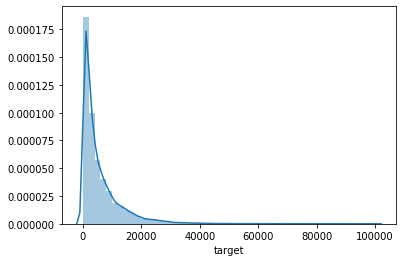

In [19]:
import seaborn as sns
sns.distplot(tar)

In [32]:
oof_tar_sub[tar>10000]

,Unnamed: 0,oof,target,sub
16,16,10892.245181,10500,392.245181
31,31,12662.233511,12900,-237.766489
33,33,14010.276655,14000,10.276655
34,34,17709.096363,17300,409.096363
46,46,9476.323708,10500,-1023.676292
50,50,10294.624998,12000,-1705.375002
52,52,8769.053364,11599,-2829.946636
74,74,15258.453358,17950,-2691.546642
76,76,12305.162416,11500,805.162416
77,77,19182.962812,19780,-597.037188
